## Installations

## Imports

In [34]:
from dotenv import find_dotenv, load_dotenv
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from warnings import filterwarnings
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns  
from datetime import datetime, timezone
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import shap
filterwarnings("ignore")



In [15]:
load_dotenv(find_dotenv())

PROJECT_PATH=os.getenv('PROJECT_PATH')
MAX_T=int(os.getenv('MAX_T'))
RISING_LABEL=1

In [57]:
def read_file(file):
    df=pd.read_csv(file)

    return df


def get_all_players(df):
    all_whites=list(set(sorted(df["White"])))
    all_whites=sorted(all_whites)
    all_black=list(set(sorted(df["Black"])))
    all_black=sorted(all_black)
    all_players=list(set(all_whites+all_black))
    return all_players
def get_events_for_player(df,player):
    return Counter(list(df[(df["White"]==player)|(df["Black"]==player)]["Event"]))
def get_games_for_player(df,player):
    return df[(df["White"]==player)|(df["Black"]==player)]

def get_years_for_player(df,player):
    return dict(Counter(list(df[(df["White"]==player)|(df["Black"]==player)]["Year"])))
def get_years_for_player_game(df,player,game):
    return dict(Counter(list(df[((df["White"]==player)|(df["Black"]==player))&(df["Event"]==game)]["Year"])))
def get_players(df):
    w=list(df["White"])
    b=list(df["Black"])
    all=list(set((w+b)))
    return all

def get_games_for_player(df,player):
    player_black_df=df[df["Black"]==player]
    player_black_df=player_black_df[["UTCDate","BlackElo","UTCTime"]]
    player_black_df.rename(columns={'BlackElo':'Elo'},inplace=True)

    player_white_df=df[df["White"]==player]
    player_white_df=player_white_df[["UTCDate","WhiteElo","UTCTime"]]
    player_white_df.rename(columns={'WhiteElo':'Elo'},inplace=True)

    return pd.concat([player_black_df,player_white_df]).sort_values(by='UTCDate')


def date_to_num(date_str):
    # Parse the date string to datetime object
    date_obj = datetime.strptime(date_str, "%Y.%m.%d %H:%M:%S")

    # Convert the datetime object to Unix timestamp (seconds since epoch)
    unix_timestamp = date_obj.replace(tzinfo=timezone.utc).timestamp()
    return unix_timestamp

def get_players_atleast_x_games_type(x,game_type,df):

    df_c=(df[df["Event"]==" Blitz "])
    w=dict(df_c["White"].value_counts())
    b=dict(df_c["Black"].value_counts())
    all={}
    all=w
    for k,v in b.items():
        all[k]=all.get(k,0)+v
    h=[]
    for k,v in w.items():
        if v>200:
            h.append(k)
    len(h)

    #
    df=df[(df["White"].isin(h))|(df["Black"].isin(h))]

    #
    df1=df[(df["White"].isin(h))&(df["Black"].isin(h))]
    df1=df1[["White","WhiteElo","UTCDate","UTCTime"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    df2=df[(df["White"].isin(h))&(~df["Black"].isin(h))]
    df2=df2[["White","WhiteElo","UTCDate","UTCTime"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    #
    df3=df[(~df["White"].isin(h))&(df["Black"].isin(h))]
    df3=df3[["Black","BlackElo","UTCDate","UTCTime"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df4=df[(df["White"].isin(h))&(df["Black"].isin(h))]
    df4=df4[["Black","BlackElo","UTCDate","UTCTime"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df=pd.concat([df1,df2,df3,df4])
    return df

def classify(df,test_size,model,name):
    train, test = train_test_split(df, test_size=test_size)
    y_train, y_test = train['label'], test['label']
    X_train, X_test = train.drop('label', axis=1), test.drop('label', axis=1)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print("-"*100)
    print("Model name:",name)
    print("accuracy_score:",accuracy_score(y_test,y_predict))
    print("roc_auc_score:",roc_auc_score(y_test,y_predict))
    print("precision_score:",precision_score(y_test,y_predict))
    print("f1_score:",f1_score(y_test,y_predict))
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    print("-"*100)
    try:
        explainer = shap.Explainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test)
    except Exception as err:
        pass
    return {
        'model':model,
        'accuracy':accuracy_score(y_test,y_predict),
        'precision':precision_score(y_test,y_predict),
        'recall':recall_score(y_test,y_predict),
        'f1':f1_score(y_test,y_predict),
        'name':name
           }
    
def compare_model_results(results):

    a, p, r, f,names = [], [], [], [],[]
    for res in results:
        a.append(res["accuracy"])
        p.append(res["precision"])
        r.append(res["recall"])
        f.append(res["f1"])
        names.append(res["name"])

    #
    model_score = pd.DataFrame([a,p,r,f],
                 columns = names).T.sort_values(by=3, ascending=False).rename(columns={0:'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1',}).round(4) 
    # Create a heatmap of the summary
    plt.figure(figsize= (10,10))
    sns.heatmap(model_score, annot=True, cmap = 'coolwarm')
    plt.show()
    

##  find features

In [37]:
with open(f"{PROJECT_PATH}/models/fics/player_series_labels_150_euclidean.pkl", 'rb') as f:
    player_series_labels=pickle.load(f)
players=set(player_series_labels.keys())

In [47]:
chunksize = 10 ** 7
rich_players_data={p:[] for p in players}

with pd.read_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-standard-rated-filtered.csv", chunksize=chunksize) as reader:
    for chunk in reader:
        print("read")
        chunk=chunk[(chunk["White"].isin(players))|(chunk["Black"].isin(players))]
        chunk["Year"]=chunk["Date"].apply(lambda r:int(r.split(".")[0]))
        chunk["Month"]=chunk["Date"].apply(lambda r:int(r.split(".")[1]))
        chunk["Day"]=chunk["Date"].apply(lambda r:int(r.split(".")[2]))
        chunk["Timestamp"]=(chunk["Date"]+" "+chunk["Time"]).apply(lambda r:date_to_num(r))
        for p in tqdm(players):
            ts=player_series_labels[p]['ts']
            cond_1=(chunk["Timestamp"]>=min(ts))
            cond_2=(chunk["Timestamp"]<=max(ts))
            cond_3=((chunk["White"]==p)|(chunk["Black"]==p))
            chunk_filtered=chunk[cond_1&cond_2&cond_3]
            rich_players_data[p].append(chunk_filtered)

for p in players:
    rich_players_data[p]=pd.concat(rich_players_data[p])


read


100%|██████████| 5933/5933 [40:24<00:00,  2.45it/s]


read


100%|██████████| 5933/5933 [29:56<00:00,  3.30it/s]


In [48]:
with open(f"{PROJECT_PATH}/models/fics/player_series_labels_150_euclidean_rich.pkl", 'wb+') as f:
    pickle.dump(rich_players_data,f)

In [49]:
with open(f"{PROJECT_PATH}/models/fics/player_series_labels_150_euclidean_rich.pkl", 'rb') as f:
    rich_players_data=pickle.load(f)



In [50]:
with open(f"{PROJECT_PATH}/models/fics/player_series_labels_150_euclidean.pkl", 'rb') as f:
    player_series_labels=pickle.load(f)
players=set(player_series_labels.keys())

In [51]:
for p in list(rich_players_data.keys()): 
    curr=rich_players_data[p]
    curr=curr.sort_values(by=["Timestamp"]).reset_index()
    curr=curr[curr.index<MAX_T]
    rich_players_data[p]=curr

In [52]:
example=rich_players_data[list(rich_players_data.keys())[0]]

In [53]:
def get_freq(my_str,c):
    return ( sum([int(s==c) for s in my_str]))

In [54]:
features_dict={
    'white_to_black_ratio':[],
    'label':[],
    'player_elo_mean':[],
    'opponent_elo_mean':[],
    'elo_diff_mean':[],
    'total_won':[],
    'total_lost':[],
    'total_draw':[],
    'avg_number_of_moves':[]

}

for p in list(rich_players_data.keys()): 
    
    # count
    curr=rich_players_data[p]
    # print(curr.columns)
    curr_w=curr[curr["White"]==p]
    curr_b=curr[curr["Black"]==p]
    total_number_of_moves_w=sum(curr_w.Moves.apply(lambda c:get_freq(c,"|")))
    total_number_of_moves_b=sum(curr_b.Moves.apply(lambda c:get_freq(c,"|")))

    avg__number_of_moves=(total_number_of_moves_w+total_number_of_moves_b)/len(curr)
    features_dict["avg_number_of_moves"].append(avg__number_of_moves)




    total_won_as_w=len(curr[(curr["Result"]=="1-0")&(curr["White"]==p)])
    total_lost_as_w=len(curr[(curr["Result"]=="0-1")&(curr["White"]==p)])
    total_won_as_b=len(curr[(curr["Result"]=="0-1")&(curr["Black"]==p)])
    total_lost_as_b=len(curr[(curr["Result"]=="1-0")&(curr["Black"]==p)])
    total_won=total_won_as_w+total_won_as_b
    total_lost=total_lost_as_w+total_lost_as_b
    total_draw=len(curr)-total_won-total_lost
    features_dict["total_won"].append(total_won)
    features_dict["total_lost"].append(total_lost)
    features_dict["total_draw"].append(total_draw)
    total_number_of_moves=sum(curr.Moves.apply(lambda c:get_freq(c,"|")))
    avg__number_of_moves=total_number_of_moves/len(curr)

    #
    black_freq=dict(Counter(curr["Black"]))
    white_freq=dict(Counter(curr["White"]))
    result_freq=dict(Counter(curr["Result"]))
    white_to_black_ratio=white_freq.get(p,0)/(MAX_T)
    features_dict["white_to_black_ratio"].append(white_to_black_ratio)
    
    #
    player_elo=list(curr[curr["White"]==p]["WhiteElo"])+list(curr[curr["Black"]==p]["BlackElo"])
    opponent_elo=list(curr[curr["White"]!=p]["WhiteElo"])+list(curr[curr["Black"]!=p]["BlackElo"])
    player_elo_mean=np.mean(player_elo)
    opponent_elo_mean=np.mean(opponent_elo)
    elo_diff=[r["WhiteElo"]-r["BlackElo"] for (_,r) in curr.iterrows()]
    elo_diff_mean=sum(elo_diff)/len(curr)
    #
    features_dict["elo_diff_mean"].append(elo_diff_mean)
    features_dict["player_elo_mean"].append(player_elo_mean)
    features_dict["opponent_elo_mean"].append(opponent_elo_mean)



    # label
    label=player_series_labels[p]['label'][0]
    label=int(player_series_labels[p]["label"][0]==RISING_LABEL)
    features_dict["label"].append(label)


df=pd.DataFrame.from_dict(features_dict)
df

,white_to_black_ratio,label,player_elo_mean,opponent_elo_mean,elo_diff_mean,total_won,total_lost,total_draw,avg_number_of_moves
0,0.50,1,1245.74,1473.04,22.70,11,39,0,40.72
1,0.54,0,1476.54,1433.70,10.80,24,24,2,53.96
2,0.38,0,1728.86,1546.98,-47.76,36,13,1,68.92
3,0.50,1,1482.54,1625.96,-8.74,21,26,3,74.06
4,0.50,0,1671.88,1498.60,-33.52,34,16,0,69.22
...,...,...,...,...,...,...,...,...,...
5928,0.40,0,1576.32,1663.60,6.16,14,35,1,57.24
5929,0.56,0,1747.54,1697.54,14.76,25,23,2,67.20
5930,0.46,0,1973.52,2071.82,13.10,17,31,2,62.00
5931,0.44,1,2153.18,1997.98,-40.00,36,11,3,57.02


In [55]:
models=[]

#### logistic regression

----------------------------------------------------------------------------------------------------
Model name: logistic regression
accuracy_score: 0.6512215669755687
roc_auc_score: 0.542847204265327
precision_score: 0.559322033898305
f1_score: 0.24175824175824176
----------------------------------------------------------------------------------------------------


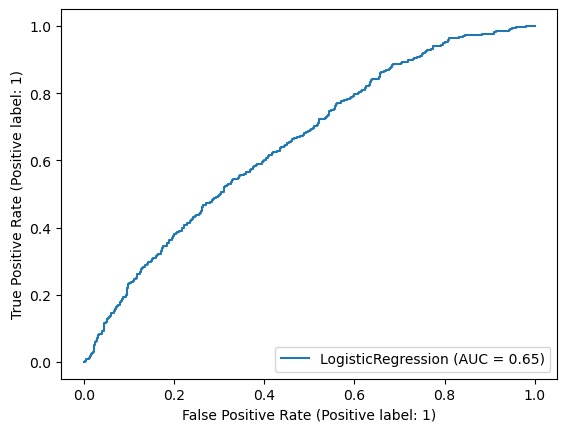

In [58]:
from sklearn.linear_model import LogisticRegression
models.append(classify(df,0.2,LogisticRegression(),"logistic regression"))

#### Support vector machines

----------------------------------------------------------------------------------------------------
Model name: Support vector machine
accuracy_score: 0.6183656276326874
roc_auc_score: 0.5
precision_score: 0.0
f1_score: 0.0
----------------------------------------------------------------------------------------------------


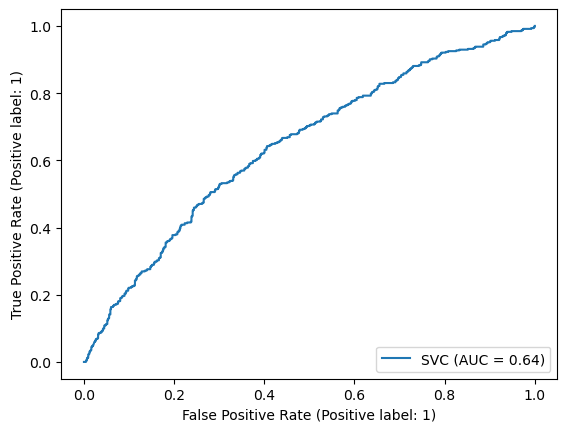

In [60]:
from sklearn.svm import SVC
models.append(classify(df,0.2,SVC(probability =True),"Support vector machine"))

#### Random Forrest

----------------------------------------------------------------------------------------------------
Model name: basic random forrest
accuracy_score: 0.6310025273799494
roc_auc_score: 0.525045255861186
precision_score: 0.41397849462365593
f1_score: 0.26013513513513514
----------------------------------------------------------------------------------------------------


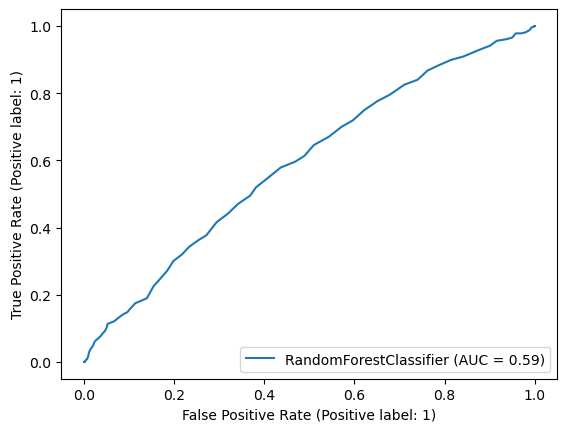

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
models.append(classify(df,0.2,RandomForestClassifier(n_estimators=100, random_state=42),"basic random forrest"))

#### Decision Tree

----------------------------------------------------------------------------------------------------
Model name: decision tree
accuracy_score: 0.5644481887110362
roc_auc_score: 0.514672222640279
precision_score: 0.3661616161616162
f1_score: 0.3593556381660471
----------------------------------------------------------------------------------------------------


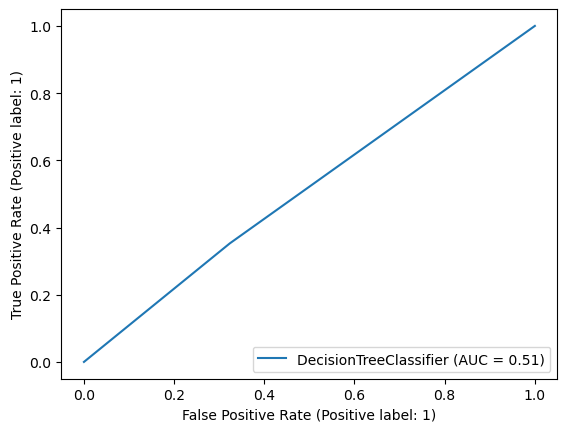

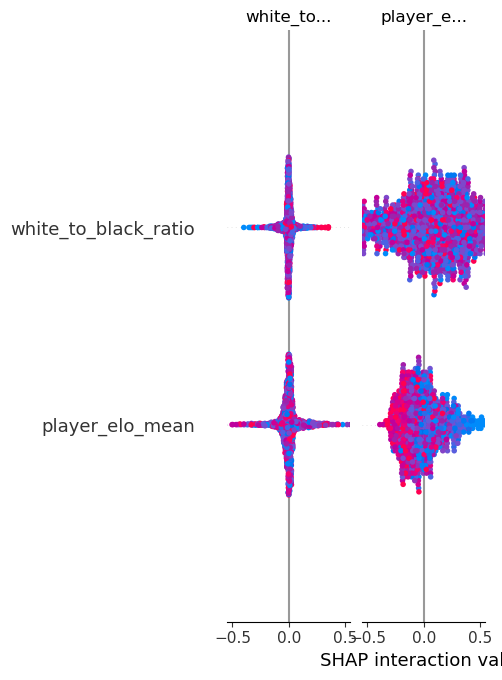

In [61]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
models.append(classify(df,0.2,DecisionTreeClassifier(random_state=42),"decision tree"))

#### Gaussian Naive Bayes

----------------------------------------------------------------------------------------------------
Model name: Gaussian Naive Bayes
accuracy_score: 0.632687447346251
roc_auc_score: 0.5158066882494877
precision_score: 0.6052631578947368
f1_score: 0.09543568464730288
----------------------------------------------------------------------------------------------------


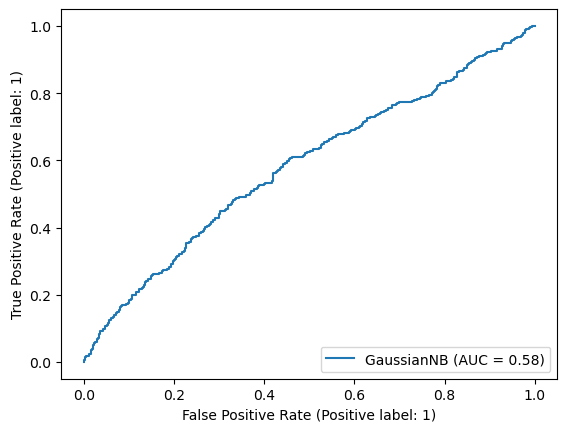

In [62]:
from sklearn.naive_bayes import GaussianNB  # For Gaussian Naive Bayes
models.append(classify(df,0.2,GaussianNB(),"Gaussian Naive Bayes"))

#### KNN

----------------------------------------------------------------------------------------------------
Model name: KNeighborsClassifier
accuracy_score: 0.624262847514743
roc_auc_score: 0.5112773066369672
precision_score: 0.39705882352941174
f1_score: 0.19494584837545123
----------------------------------------------------------------------------------------------------


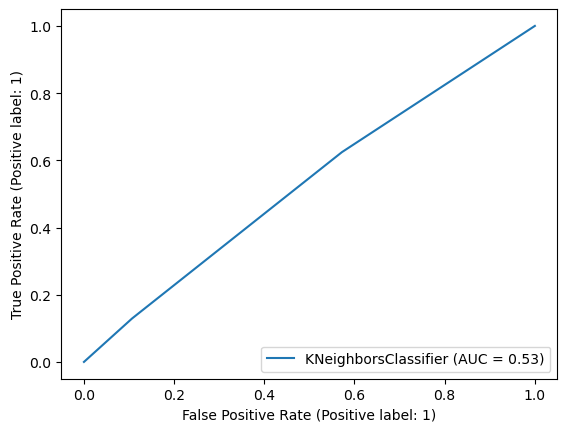

In [63]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier  
models.append(classify(df,0.2,KNeighborsClassifier(2),"KNeighborsClassifier"))

#### AdaBoostClassifier

----------------------------------------------------------------------------------------------------
Model name: AdaBoostClassifier
accuracy_score: 0.6579612468407751
roc_auc_score: 0.5391365484385913
precision_score: 0.5462962962962963
f1_score: 0.22519083969465647
----------------------------------------------------------------------------------------------------


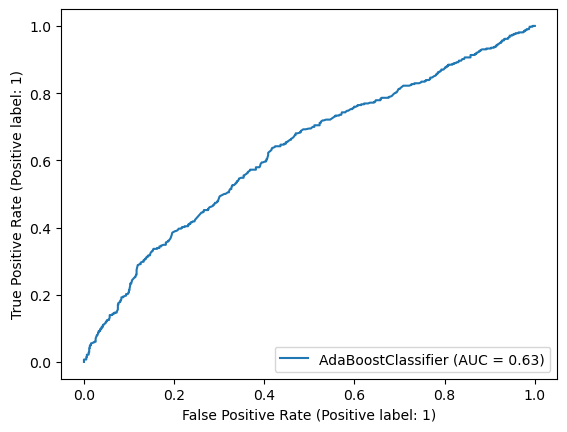

In [64]:
models.append(classify(df,0.2,AdaBoostClassifier(),"AdaBoostClassifier"))

#### CatBoostClassifier

Learning rate set to 0.020032
0:	learn: 0.6906860	total: 1.79ms	remaining: 1.79s
1:	learn: 0.6885701	total: 3.72ms	remaining: 1.86s
2:	learn: 0.6864700	total: 5.47ms	remaining: 1.82s
3:	learn: 0.6845872	total: 7.08ms	remaining: 1.76s
4:	learn: 0.6825689	total: 12ms	remaining: 2.38s
5:	learn: 0.6806970	total: 13.3ms	remaining: 2.21s
6:	learn: 0.6787770	total: 14.6ms	remaining: 2.07s
7:	learn: 0.6768493	total: 15.9ms	remaining: 1.97s
8:	learn: 0.6752145	total: 17ms	remaining: 1.87s
9:	learn: 0.6736418	total: 18.2ms	remaining: 1.8s
10:	learn: 0.6720316	total: 19.3ms	remaining: 1.73s
11:	learn: 0.6705848	total: 20.4ms	remaining: 1.68s
12:	learn: 0.6691364	total: 21.5ms	remaining: 1.63s
13:	learn: 0.6675895	total: 22.5ms	remaining: 1.58s
14:	learn: 0.6663424	total: 23.5ms	remaining: 1.55s
15:	learn: 0.6650200	total: 24.5ms	remaining: 1.51s
16:	learn: 0.6637545	total: 25.5ms	remaining: 1.47s
17:	learn: 0.6626648	total: 26.4ms	remaining: 1.44s
18:	learn: 0.6614110	total: 27.3ms	remaining: 1.4

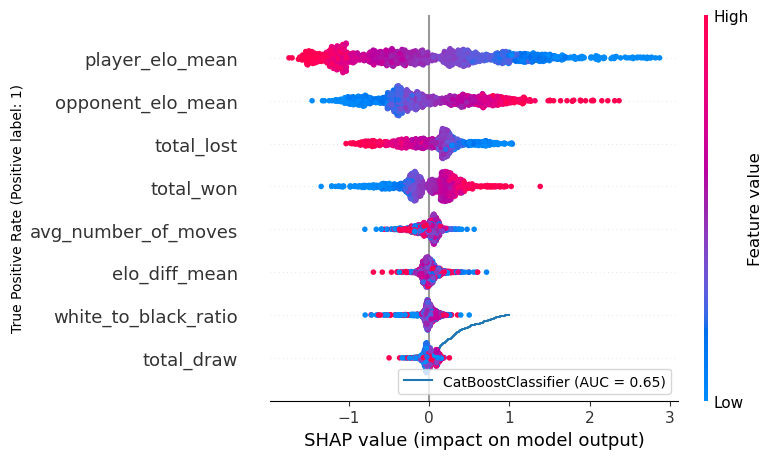

In [65]:
models.append(classify(df,0.2,CatBoostClassifier(),"CatBoostClassifier"))

#### XGBOOST

----------------------------------------------------------------------------------------------------
Model name: XGBClassifier
accuracy_score: 0.6478517270429655
roc_auc_score: 0.5609776168531929
precision_score: 0.46987951807228917
f1_score: 0.35889570552147243
----------------------------------------------------------------------------------------------------


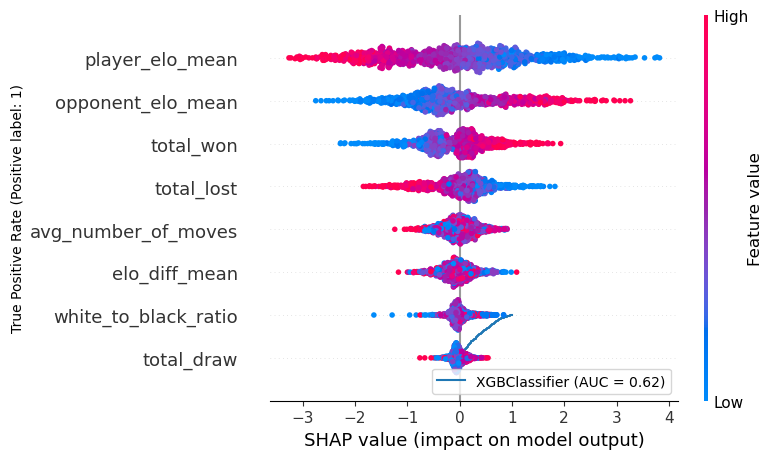

In [66]:
models.append(classify(df,0.2,XGBClassifier(),"XGBClassifier"))

#### Comparision

In [67]:
%matplotlib inline
def compare_model_results(results):

    a, p, r, f,names = [], [], [], [],[]
    for res in results:
        a.append(res["accuracy"])
        p.append(res["precision"])
        r.append(res["recall"])
        f.append(res["f1"])
        names.append(res["name"])
    #
    model_score = pd.DataFrame([a,p,r,f],
                 columns = names).T.sort_values(by=3, ascending=False).rename(columns={0:'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1',}).round(4) 
    print(model_score)


compare_model_results(models)

                        Accuracy  Precision  Recall      F1
decision tree             0.5644     0.3662  0.3528  0.3594
XGBClassifier             0.6479     0.4699  0.2903  0.3589
CatBoostClassifier        0.6554     0.5062  0.1971  0.2837
logistic regression       0.6512     0.5593  0.1542  0.2418
AdaBoostClassifier        0.6580     0.5463  0.1418  0.2252
KNeighborsClassifier      0.6243     0.3971  0.1292  0.1949
Gaussian Naive Bayes      0.6327     0.6053  0.0518  0.0954
Support vector machine    0.6445     0.0000  0.0000  0.0000
Support vector machine    0.6184     0.0000  0.0000  0.0000
